# Person Attribute Recognition demo

동영상에서 객체 추적 결과를 바탕으로, 보행자 속성 인식(PAR) 모델로 추론하는 코드

[Yukun-Huang/Person-Attribute-Recognition-MarketDuke](https://github.com/Yukun-Huang/Person-Attribute-Recognition-MarketDuke) 저장소의 inference.py 코드 사용

환경 설정은 되어있다 가정 (`torch` 만 깔려 있으면 큰 문제 없음)

## 동영상 및 객체 추적 결과 불러오기

In [1]:
import requests
from io import StringIO

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cap = cv2.VideoCapture('/home/kh/notebooks/assets/street.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)

res = requests.get('https://gist.githubusercontent.com/khleexv/2a7a120ed3ad78775853ec118573142c/raw/be05a5ecab746606bebb02d7b03fbc5ae5dabb79/street.txt')
result = res.content.decode('utf-8')

df = pd.read_csv(StringIO(result),
                 names=['frame_id', 'track_id', 'left', 'top', 'width', 'height', 'score', 'X1', 'X2', 'X3'])
df = df.iloc[:,:-3]
df

,frame_id,track_id,left,top,width,height,score
0,0,1,1029.94,373.22,37.35,93.46,0.87
1,0,2,1057.90,362.47,36.61,100.78,0.86
2,0,3,627.51,290.97,93.46,230.09,0.85
3,0,4,179.29,268.85,156.23,295.05,0.84
4,0,5,352.01,363.74,38.97,102.09,0.80
...,...,...,...,...,...,...,...
7973,1088,106,257.39,423.96,52.32,95.08,0.75
7974,1089,106,257.65,424.16,51.89,94.96,0.76
7975,1090,106,257.94,424.47,51.49,94.76,0.76
7976,1091,106,258.40,424.83,50.67,94.41,0.77


In [2]:
for i, row in df.query('track_id == 3').iterrows():
    frame_id, track_id, left, top, width, height, _ = row
    top = round(top)
    left = round(left)
    width = round(width)
    height = round(height)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    success, frame = cap.read()
    assert success
    break

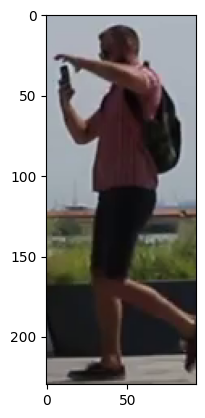

In [3]:
im = frame[top:top+height, left:left+width]
plt.imshow(im[:,:,::-1])

## PAR 모델 불러오기 & 추론

In [4]:
import sys
sys.path.append('/home/kh/capstone/PAR/Person-Attribute-Recognition-MarketDuke')

import os
import json
import torch
import argparse
from PIL import Image
from torchvision import transforms as T
from net import get_model

print(sys.version)
print(torch.__version__)

3.12.2 | packaged by Anaconda, Inc. | (main, Feb 27 2024, 17:35:02) [GCC 11.2.0]
2.2.1


In [5]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize(size=(288, 144)),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model_name = 'resnet50_nfc_id'
num_label = 30
num_id = 751

model = get_model(model_name, num_label, use_id=False, num_id=num_id)

save_path = '/home/kh/capstone/PAR/Person-Attribute-Recognition-MarketDuke/checkpoints/market/resnet50_nfc/net_last.pth'
model.load_state_dict(torch.load(save_path))

model.eval();

/home/kh/miniconda3/envs/openpar/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kh/miniconda3/envs/openpar/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from collections import defaultdict

ages = defaultdict(int)
genders = defaultdict(int)
crops = []

for i, row in df.query('track_id == 3').iterrows():
    frame_id, track_id, left, top, width, height, _ = row
    top = round(top)
    left = round(left)
    width = round(width)
    height = round(height)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    success, frame = cap.read()

    assert success

    crop = src = frame[top:top+ height, left:left+width]
    crops.append(crop)

    w, h, _ = src.shape
    if w < 10 or h < 10: # 탐지된 이미지가 너무 작은 경우 추론 X
        continue
    
    src = transforms(src)
    src = src.unsqueeze(0)
    with torch.no_grad():
        out = model.forward(src)
    age_idx = out[0,:4].argmax()
    ages[['young', 'teenager', 'adult', 'old'][age_idx]] += 1

    gender = 'male' if out[0, 12] < 0.5 else 'female'
    genders[gender] += 1

In [8]:
print('ages    :', ages)
print('genders :', genders)

ages    : defaultdict(<class 'int'>, {'teenager': 64})
genders : defaultdict(<class 'int'>, {'male': 57, 'female': 7})
